# Creación de un ejemplo adversarial

Link del tutorial : https://medium.com/mindboard/generating-adversarial-samples-in-keras-tutorial-f881ac836246

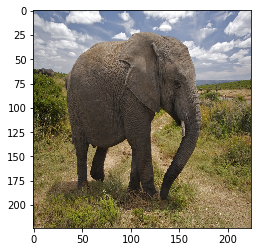

In [12]:

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten ,Input
from keras.layers import Conv2D, MaxPooling2D, Reshape, Add
from keras.metrics import categorical_accuracy
from keras.regularizers import l1_l2, l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from tensorflow.python.keras import backend as K
from keras.preprocessing.image import array_to_img,img_to_array

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
##Funciones auxiliares
def plotImage( img, dims = False ):
    if not(dims):
        plt.imshow(img, vmin=0., vmax=1.)
    else: 
        plt.imshow(img.reshape(dims), vmin=0., vmax=1.)
    plt.show()
        

#Instanciacion del modelo resnet
model = ResNet50(weights='imagenet')


##Imagen de elefante
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plotImage(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x_not_pre = x

# Imagen preprocesada para tener el formato que acepta resnet
x = preprocess_input(x)





Eligamos una imagen para crear ejemplo adversarial

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


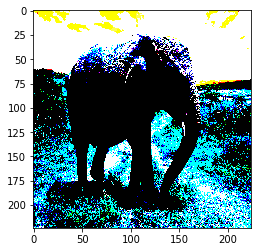

(1, 224, 224, 3)
Valor máximo 151
Valor mínimo -121


In [13]:
#select image to create an adversarial example from
plotImage(x[0])
print(x.shape)
print("Valor máximo %d" % np.max(x))
print("Valor mínimo %d" % np.min(x))

Veamos qué clasificacion da el modelo

In [14]:
preds = model.predict(x)
print(preds.shape)
print(np.argmax(preds[0]))
print('Predicción:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

(1, 1000)
386
Predicción: [('n02504458', 'African_elephant', 0.86625427), ('n02504013', 'Indian_elephant', 0.06860924), ('n01871265', 'tusker', 0.06478469)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max valor absoluto del ruido 362.7861729321757


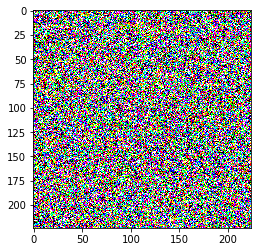

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen original


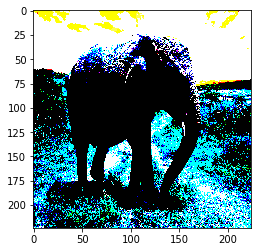

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen ruido


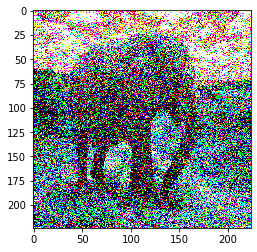

Predicted: [('n02999410', 'chain', 0.40553063), ('n02504458', 'African_elephant', 0.27195418), ('n04208210', 'shovel', 0.06421838)]


In [15]:
factor = 80
ruido = np.random.normal(loc=0.0, scale=1, size=x.shape)*factor
print('Max valor absoluto del ruido', np.max(np.abs(ruido)))
plotImage(ruido[0])
img_ruido = x + ruido
print("Imagen original")
plotImage(x[0])
print("Imagen ruido")
plotImage(img_ruido[0])
preds = model.predict(img_ruido)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [17]:

#custom loss funciton for non-targeted misclassification
def negative_categorical_crossentropy(yTrue,yPred):
    return 0.0 - K.categorical_crossentropy(yTrue,yPred)

#add custom objects to dictionary
get_custom_objects().update({'negative_categorical_crossentropy': negative_categorical_crossentropy})

def define_adversarial_model(img_shape, regularization, classifier):
    h = img_shape[0]
    w = img_shape[1]
    numChannels = img_shape[2]
    
    #Input imagen base
    image = Input(shape=img_shape,name='image')
    #unidad para ruido adversarial
    one = Input(shape=(1,),name='unity')
    
    #Capa de ruido
    noise = Dense(h*w*numChannels,activation = None,use_bias=False,kernel_initializer='random_normal',
                  kernel_regularizer=regularization, name='adversarial_noise')(one)
    
    #Cambia el shape del ruido igual al de la imagen
    noise = Reshape(img_shape, name='reshape')(noise)
    
    #Suma de las capas
    net = Add(name='add')([noise,image])
    
    #conecta imagen con ruido adversarial a classificador
    outputs = classifier(net)
    outputs = Reshape((1000,), name='reshape_resnet')(outputs)

    adversarial_model = Model(inputs=[image,one], outputs=outputs)
    #vuelve estáticos los parametros del classificador, solo entrena capa de ruido
    adversarial_model.layers[-1].trainable = False
    adversarial_model.layers[-2].trainable = False
    return adversarial_model

def entrena_modelo_adversarial(adversarial_model, target, img, num_epocas):
    target_vector = np.zeros(1000)
    target_vector[target] = 1.
    
    #callback para guardar el modelo 
    checkpoint = ModelCheckpoint('./adversarial_weights_resnet.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True,
                                mode='auto', period=1)
    #entrenamiento
    adversarial_model.fit(x={'image':img,'unity':np.ones(shape=(1,1))},y=target_vector.reshape(1,-1),epochs=num_epocas,verbose=2,
    callbacks=[checkpoint])
    
    #Carga mejores parametros
    adversarial_model.load_weights('./adversarial_weights_resnet.h5')
    
def recupera_ruido(adversarial_model):
    #quantize adversarial noise
    quantized_weights = np.round(adversarial_model.get_weights()[0].reshape((224,224,3)) * 255.) / 255.
    weights = adversarial_model.get_weights()[0].reshape((224,224,3))
    return weights

def clasifica_resnet(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    prediccion =  model.predict(img)
    return decode_predictions(prediccion, top=3)[0]
def clasifica_mod_adversarial(inp, net):
    pred =  net.predict(inp)
    return decode_predictions(pred, top=3)[0]
#generate_adversary(x_not_pre,5,model,l1(0.01),'negative_categorical_crossentropy')


In [18]:
adversarial_model = define_adversarial_model((224,224,3),l1(0.0000001),model)
adversarial_model.compile(optimizer='nadam', loss='negative_categorical_crossentropy', metrics=[categorical_accuracy])

In [21]:
target = 386
target_vector = np.zeros((1,1000))
target_vector[0, target] = 1
print(decode_predictions(target_vector, top = 3)[0])

[('n02504458', 'African_elephant', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02317335', 'starfish', 0.0)]


In [14]:
entrena_modelo_adversarial(adversarial_model,target,x, 2000)

[('n02504458', 'African_elephant', 1.0), ('n15075141', 'toilet_tissue', 0.0), ('n02317335', 'starfish', 0.0)]
Epoch 1/2000
 - 0s - loss: -9.9972e+00 - categorical_accuracy: 0.0000e+00
Epoch 2/2000
 - 0s - loss: -9.9998e+00 - categorical_accuracy: 0.0000e+00
Epoch 3/2000
 - 0s - loss: -1.0002e+01 - categorical_accuracy: 0.0000e+00
Epoch 4/2000
 - 0s - loss: -1.0005e+01 - categorical_accuracy: 0.0000e+00
Epoch 5/2000
 - 0s - loss: -1.0008e+01 - categorical_accuracy: 0.0000e+00
Epoch 6/2000
 - 0s - loss: -1.0011e+01 - categorical_accuracy: 0.0000e+00
Epoch 7/2000
 - 0s - loss: -1.0014e+01 - categorical_accuracy: 0.0000e+00
Epoch 8/2000
 - 0s - loss: -1.0016e+01 - categorical_accuracy: 0.0000e+00
Epoch 9/2000
 - 0s - loss: -1.0019e+01 - categorical_accuracy: 0.0000e+00
Epoch 10/2000
 - 0s - loss: -1.0022e+01 - categorical_accuracy: 0.0000e+00
Epoch 11/2000
 - 0s - loss: -1.0025e+01 - categorical_accuracy: 0.0000e+00
Epoch 12/2000
 - 0s - loss: -1.0028e+01 - categorical_accuracy: 0.0000e+00

Epoch 109/2000
 - 0s - loss: -1.0289e+01 - categorical_accuracy: 0.0000e+00
Epoch 110/2000
 - 0s - loss: -1.0292e+01 - categorical_accuracy: 0.0000e+00
Epoch 111/2000
 - 0s - loss: -1.0294e+01 - categorical_accuracy: 0.0000e+00
Epoch 112/2000
 - 0s - loss: -1.0297e+01 - categorical_accuracy: 0.0000e+00
Epoch 113/2000
 - 0s - loss: -1.0299e+01 - categorical_accuracy: 0.0000e+00
Epoch 114/2000
 - 0s - loss: -1.0302e+01 - categorical_accuracy: 0.0000e+00
Epoch 115/2000
 - 0s - loss: -1.0305e+01 - categorical_accuracy: 0.0000e+00
Epoch 116/2000
 - 0s - loss: -1.0307e+01 - categorical_accuracy: 0.0000e+00
Epoch 117/2000
 - 0s - loss: -1.0310e+01 - categorical_accuracy: 0.0000e+00
Epoch 118/2000
 - 0s - loss: -1.0312e+01 - categorical_accuracy: 0.0000e+00
Epoch 119/2000
 - 0s - loss: -1.0315e+01 - categorical_accuracy: 0.0000e+00
Epoch 120/2000
 - 0s - loss: -1.0318e+01 - categorical_accuracy: 0.0000e+00
Epoch 121/2000
 - 0s - loss: -1.0320e+01 - categorical_accuracy: 0.0000e+00
Epoch 122/20

Epoch 217/2000
 - 0s - loss: -1.0549e+01 - categorical_accuracy: 0.0000e+00
Epoch 218/2000
 - 0s - loss: -1.0551e+01 - categorical_accuracy: 0.0000e+00
Epoch 219/2000
 - 0s - loss: -1.0554e+01 - categorical_accuracy: 0.0000e+00
Epoch 220/2000
 - 0s - loss: -1.0556e+01 - categorical_accuracy: 0.0000e+00
Epoch 221/2000
 - 0s - loss: -1.0558e+01 - categorical_accuracy: 0.0000e+00
Epoch 222/2000
 - 0s - loss: -1.0561e+01 - categorical_accuracy: 0.0000e+00
Epoch 223/2000
 - 0s - loss: -1.0563e+01 - categorical_accuracy: 0.0000e+00
Epoch 224/2000
 - 0s - loss: -1.0565e+01 - categorical_accuracy: 0.0000e+00
Epoch 225/2000
 - 0s - loss: -1.0567e+01 - categorical_accuracy: 0.0000e+00
Epoch 226/2000
 - 0s - loss: -1.0570e+01 - categorical_accuracy: 0.0000e+00
Epoch 227/2000
 - 0s - loss: -1.0572e+01 - categorical_accuracy: 0.0000e+00
Epoch 228/2000
 - 0s - loss: -1.0574e+01 - categorical_accuracy: 0.0000e+00
Epoch 229/2000
 - 0s - loss: -1.0577e+01 - categorical_accuracy: 0.0000e+00
Epoch 230/20

Epoch 325/2000
 - 0s - loss: -1.0778e+01 - categorical_accuracy: 0.0000e+00
Epoch 326/2000
 - 0s - loss: -1.0780e+01 - categorical_accuracy: 0.0000e+00
Epoch 327/2000
 - 0s - loss: -1.0782e+01 - categorical_accuracy: 0.0000e+00
Epoch 328/2000
 - 0s - loss: -1.0784e+01 - categorical_accuracy: 0.0000e+00
Epoch 329/2000
 - 0s - loss: -1.0786e+01 - categorical_accuracy: 0.0000e+00
Epoch 330/2000
 - 0s - loss: -1.0788e+01 - categorical_accuracy: 0.0000e+00
Epoch 331/2000
 - 0s - loss: -1.0789e+01 - categorical_accuracy: 0.0000e+00
Epoch 332/2000
 - 0s - loss: -1.0790e+01 - categorical_accuracy: 0.0000e+00
Epoch 333/2000
 - 0s - loss: -1.0792e+01 - categorical_accuracy: 0.0000e+00
Epoch 334/2000
 - 0s - loss: -1.0795e+01 - categorical_accuracy: 0.0000e+00
Epoch 335/2000
 - 0s - loss: -1.0797e+01 - categorical_accuracy: 0.0000e+00
Epoch 336/2000
 - 0s - loss: -1.0799e+01 - categorical_accuracy: 0.0000e+00
Epoch 337/2000
 - 0s - loss: -1.0800e+01 - categorical_accuracy: 0.0000e+00
Epoch 338/20

Epoch 433/2000
 - 0s - loss: -1.0978e+01 - categorical_accuracy: 0.0000e+00
Epoch 434/2000
 - 0s - loss: -1.0980e+01 - categorical_accuracy: 0.0000e+00
Epoch 435/2000
 - 0s - loss: -1.0982e+01 - categorical_accuracy: 0.0000e+00
Epoch 436/2000
 - 0s - loss: -1.0985e+01 - categorical_accuracy: 0.0000e+00
Epoch 437/2000
 - 0s - loss: -1.0987e+01 - categorical_accuracy: 0.0000e+00
Epoch 438/2000
 - 0s - loss: -1.0989e+01 - categorical_accuracy: 0.0000e+00
Epoch 439/2000
 - 0s - loss: -1.0990e+01 - categorical_accuracy: 0.0000e+00
Epoch 440/2000
 - 0s - loss: -1.0991e+01 - categorical_accuracy: 0.0000e+00
Epoch 441/2000
 - 0s - loss: -1.0994e+01 - categorical_accuracy: 0.0000e+00
Epoch 442/2000
 - 0s - loss: -1.0996e+01 - categorical_accuracy: 0.0000e+00
Epoch 443/2000
 - 0s - loss: -1.0997e+01 - categorical_accuracy: 0.0000e+00
Epoch 444/2000
 - 0s - loss: -1.1000e+01 - categorical_accuracy: 0.0000e+00
Epoch 445/2000
 - 0s - loss: -1.1002e+01 - categorical_accuracy: 0.0000e+00
Epoch 446/20

Epoch 541/2000
 - 0s - loss: -1.1171e+01 - categorical_accuracy: 0.0000e+00
Epoch 542/2000
 - 0s - loss: -1.1173e+01 - categorical_accuracy: 0.0000e+00
Epoch 543/2000
 - 0s - loss: -1.1175e+01 - categorical_accuracy: 0.0000e+00
Epoch 544/2000
 - 0s - loss: -1.1177e+01 - categorical_accuracy: 0.0000e+00
Epoch 545/2000
 - 0s - loss: -1.1179e+01 - categorical_accuracy: 0.0000e+00
Epoch 546/2000
 - 0s - loss: -1.1181e+01 - categorical_accuracy: 0.0000e+00
Epoch 547/2000
 - 0s - loss: -1.1182e+01 - categorical_accuracy: 0.0000e+00
Epoch 548/2000
 - 0s - loss: -1.1184e+01 - categorical_accuracy: 0.0000e+00
Epoch 549/2000
 - 0s - loss: -1.1186e+01 - categorical_accuracy: 0.0000e+00
Epoch 550/2000
 - 0s - loss: -1.1187e+01 - categorical_accuracy: 0.0000e+00
Epoch 551/2000
 - 0s - loss: -1.1189e+01 - categorical_accuracy: 0.0000e+00
Epoch 552/2000
 - 0s - loss: -1.1191e+01 - categorical_accuracy: 0.0000e+00
Epoch 553/2000
 - 0s - loss: -1.1193e+01 - categorical_accuracy: 0.0000e+00
Epoch 554/20

Epoch 649/2000
 - 0s - loss: -1.1358e+01 - categorical_accuracy: 0.0000e+00
Epoch 650/2000
 - 0s - loss: -1.1360e+01 - categorical_accuracy: 0.0000e+00
Epoch 651/2000
 - 0s - loss: -1.1361e+01 - categorical_accuracy: 0.0000e+00
Epoch 652/2000
 - 0s - loss: -1.1364e+01 - categorical_accuracy: 0.0000e+00
Epoch 653/2000
 - 0s - loss: -1.1365e+01 - categorical_accuracy: 0.0000e+00
Epoch 654/2000
 - 0s - loss: -1.1367e+01 - categorical_accuracy: 0.0000e+00
Epoch 655/2000
 - 0s - loss: -1.1368e+01 - categorical_accuracy: 0.0000e+00
Epoch 656/2000
 - 0s - loss: -1.1370e+01 - categorical_accuracy: 0.0000e+00
Epoch 657/2000
 - 0s - loss: -1.1372e+01 - categorical_accuracy: 0.0000e+00
Epoch 658/2000
 - 0s - loss: -1.1373e+01 - categorical_accuracy: 0.0000e+00
Epoch 659/2000
 - 0s - loss: -1.1374e+01 - categorical_accuracy: 0.0000e+00
Epoch 660/2000
 - 0s - loss: -1.1376e+01 - categorical_accuracy: 0.0000e+00
Epoch 661/2000
 - 0s - loss: -1.1378e+01 - categorical_accuracy: 0.0000e+00
Epoch 662/20

Epoch 757/2000
 - 0s - loss: -1.1536e+01 - categorical_accuracy: 0.0000e+00
Epoch 758/2000
 - 0s - loss: -1.1538e+01 - categorical_accuracy: 0.0000e+00
Epoch 759/2000
 - 0s - loss: -1.1539e+01 - categorical_accuracy: 0.0000e+00
Epoch 760/2000
 - 0s - loss: -1.1541e+01 - categorical_accuracy: 0.0000e+00
Epoch 761/2000
 - 0s - loss: -1.1543e+01 - categorical_accuracy: 0.0000e+00
Epoch 762/2000
 - 0s - loss: -1.1545e+01 - categorical_accuracy: 0.0000e+00
Epoch 763/2000
 - 0s - loss: -1.1546e+01 - categorical_accuracy: 0.0000e+00
Epoch 764/2000
 - 0s - loss: -1.1548e+01 - categorical_accuracy: 0.0000e+00
Epoch 765/2000
 - 0s - loss: -1.1550e+01 - categorical_accuracy: 0.0000e+00
Epoch 766/2000
 - 0s - loss: -1.1551e+01 - categorical_accuracy: 0.0000e+00
Epoch 767/2000
 - 0s - loss: -1.1553e+01 - categorical_accuracy: 0.0000e+00
Epoch 768/2000
 - 0s - loss: -1.1555e+01 - categorical_accuracy: 0.0000e+00
Epoch 769/2000
 - 0s - loss: -1.1557e+01 - categorical_accuracy: 0.0000e+00
Epoch 770/20

Epoch 865/2000
 - 0s - loss: -1.1700e+01 - categorical_accuracy: 0.0000e+00
Epoch 866/2000
 - 0s - loss: -1.1701e+01 - categorical_accuracy: 0.0000e+00
Epoch 867/2000
 - 0s - loss: -1.1703e+01 - categorical_accuracy: 0.0000e+00
Epoch 868/2000
 - 0s - loss: -1.1705e+01 - categorical_accuracy: 0.0000e+00
Epoch 869/2000
 - 0s - loss: -1.1706e+01 - categorical_accuracy: 0.0000e+00
Epoch 870/2000
 - 0s - loss: -1.1707e+01 - categorical_accuracy: 0.0000e+00
Epoch 871/2000
 - 0s - loss: -1.1709e+01 - categorical_accuracy: 0.0000e+00
Epoch 872/2000
 - 0s - loss: -1.1710e+01 - categorical_accuracy: 0.0000e+00
Epoch 873/2000
 - 0s - loss: -1.1711e+01 - categorical_accuracy: 0.0000e+00
Epoch 874/2000
 - 0s - loss: -1.1712e+01 - categorical_accuracy: 0.0000e+00
Epoch 875/2000
 - 0s - loss: -1.1714e+01 - categorical_accuracy: 0.0000e+00
Epoch 876/2000
 - 0s - loss: -1.1715e+01 - categorical_accuracy: 0.0000e+00
Epoch 877/2000
 - 0s - loss: -1.1717e+01 - categorical_accuracy: 0.0000e+00
Epoch 878/20

Epoch 973/2000
 - 0s - loss: -1.1842e+01 - categorical_accuracy: 0.0000e+00
Epoch 974/2000
 - 0s - loss: -1.1843e+01 - categorical_accuracy: 0.0000e+00
Epoch 975/2000
 - 0s - loss: -1.1844e+01 - categorical_accuracy: 0.0000e+00
Epoch 976/2000
 - 0s - loss: -1.1846e+01 - categorical_accuracy: 0.0000e+00
Epoch 977/2000
 - 0s - loss: -1.1848e+01 - categorical_accuracy: 0.0000e+00
Epoch 978/2000
 - 0s - loss: -1.1849e+01 - categorical_accuracy: 0.0000e+00
Epoch 979/2000
 - 0s - loss: -1.1850e+01 - categorical_accuracy: 0.0000e+00
Epoch 980/2000
 - 0s - loss: -1.1852e+01 - categorical_accuracy: 0.0000e+00
Epoch 981/2000
 - 0s - loss: -1.1853e+01 - categorical_accuracy: 0.0000e+00
Epoch 982/2000
 - 0s - loss: -1.1854e+01 - categorical_accuracy: 0.0000e+00
Epoch 983/2000
 - 0s - loss: -1.1856e+01 - categorical_accuracy: 0.0000e+00
Epoch 984/2000
 - 0s - loss: -1.1856e+01 - categorical_accuracy: 0.0000e+00
Epoch 985/2000
 - 0s - loss: -1.1857e+01 - categorical_accuracy: 0.0000e+00
Epoch 986/20

Epoch 1080/2000
 - 0s - loss: -1.1970e+01 - categorical_accuracy: 0.0000e+00
Epoch 1081/2000
 - 0s - loss: -1.1971e+01 - categorical_accuracy: 0.0000e+00
Epoch 1082/2000
 - 0s - loss: -1.1972e+01 - categorical_accuracy: 0.0000e+00
Epoch 1083/2000
 - 0s - loss: -1.1972e+01 - categorical_accuracy: 0.0000e+00
Epoch 1084/2000
 - 0s - loss: -1.1974e+01 - categorical_accuracy: 0.0000e+00
Epoch 1085/2000
 - 0s - loss: -1.1975e+01 - categorical_accuracy: 0.0000e+00
Epoch 1086/2000
 - 0s - loss: -1.1976e+01 - categorical_accuracy: 0.0000e+00
Epoch 1087/2000
 - 0s - loss: -1.1977e+01 - categorical_accuracy: 0.0000e+00
Epoch 1088/2000
 - 0s - loss: -1.1979e+01 - categorical_accuracy: 0.0000e+00
Epoch 1089/2000
 - 0s - loss: -1.1980e+01 - categorical_accuracy: 0.0000e+00
Epoch 1090/2000
 - 0s - loss: -1.1981e+01 - categorical_accuracy: 0.0000e+00
Epoch 1091/2000
 - 0s - loss: -1.1982e+01 - categorical_accuracy: 0.0000e+00
Epoch 1092/2000
 - 0s - loss: -1.1983e+01 - categorical_accuracy: 0.0000e+00

Epoch 1187/2000
 - 0s - loss: -1.2080e+01 - categorical_accuracy: 0.0000e+00
Epoch 1188/2000
 - 0s - loss: -1.2081e+01 - categorical_accuracy: 0.0000e+00
Epoch 1189/2000
 - 0s - loss: -1.2082e+01 - categorical_accuracy: 0.0000e+00
Epoch 1190/2000
 - 0s - loss: -1.2083e+01 - categorical_accuracy: 0.0000e+00
Epoch 1191/2000
 - 0s - loss: -1.2084e+01 - categorical_accuracy: 0.0000e+00
Epoch 1192/2000
 - 0s - loss: -1.2084e+01 - categorical_accuracy: 0.0000e+00
Epoch 1193/2000
 - 0s - loss: -1.2086e+01 - categorical_accuracy: 0.0000e+00
Epoch 1194/2000
 - 0s - loss: -1.2087e+01 - categorical_accuracy: 0.0000e+00
Epoch 1195/2000
 - 0s - loss: -1.2088e+01 - categorical_accuracy: 0.0000e+00
Epoch 1196/2000
 - 0s - loss: -1.2089e+01 - categorical_accuracy: 0.0000e+00
Epoch 1197/2000
 - 0s - loss: -1.2091e+01 - categorical_accuracy: 0.0000e+00
Epoch 1198/2000
 - 0s - loss: -1.2091e+01 - categorical_accuracy: 0.0000e+00
Epoch 1199/2000
 - 0s - loss: -1.2093e+01 - categorical_accuracy: 0.0000e+00

Epoch 1294/2000
 - 0s - loss: -1.2184e+01 - categorical_accuracy: 0.0000e+00
Epoch 1295/2000
 - 0s - loss: -1.2185e+01 - categorical_accuracy: 0.0000e+00
Epoch 1296/2000
 - 0s - loss: -1.2186e+01 - categorical_accuracy: 0.0000e+00
Epoch 1297/2000
 - 0s - loss: -1.2187e+01 - categorical_accuracy: 0.0000e+00
Epoch 1298/2000
 - 0s - loss: -1.2188e+01 - categorical_accuracy: 0.0000e+00
Epoch 1299/2000
 - 0s - loss: -1.2189e+01 - categorical_accuracy: 0.0000e+00
Epoch 1300/2000
 - 0s - loss: -1.2190e+01 - categorical_accuracy: 0.0000e+00
Epoch 1301/2000
 - 0s - loss: -1.2190e+01 - categorical_accuracy: 0.0000e+00
Epoch 1302/2000
 - 0s - loss: -1.2191e+01 - categorical_accuracy: 0.0000e+00
Epoch 1303/2000
 - 0s - loss: -1.2192e+01 - categorical_accuracy: 0.0000e+00
Epoch 1304/2000
 - 0s - loss: -1.2193e+01 - categorical_accuracy: 0.0000e+00
Epoch 1305/2000
 - 0s - loss: -1.2194e+01 - categorical_accuracy: 0.0000e+00
Epoch 1306/2000
 - 0s - loss: -1.2196e+01 - categorical_accuracy: 0.0000e+00

Epoch 1401/2000
 - 0s - loss: -1.2279e+01 - categorical_accuracy: 0.0000e+00
Epoch 1402/2000
 - 0s - loss: -1.2280e+01 - categorical_accuracy: 0.0000e+00
Epoch 1403/2000
 - 0s - loss: -1.2280e+01 - categorical_accuracy: 0.0000e+00
Epoch 1404/2000
 - 0s - loss: -1.2282e+01 - categorical_accuracy: 0.0000e+00
Epoch 1405/2000
 - 0s - loss: -1.2282e+01 - categorical_accuracy: 0.0000e+00
Epoch 1406/2000
 - 0s - loss: -1.2283e+01 - categorical_accuracy: 0.0000e+00
Epoch 1407/2000
 - 0s - loss: -1.2283e+01 - categorical_accuracy: 0.0000e+00
Epoch 1408/2000
 - 0s - loss: -1.2285e+01 - categorical_accuracy: 0.0000e+00
Epoch 1409/2000
 - 0s - loss: -1.2285e+01 - categorical_accuracy: 0.0000e+00
Epoch 1410/2000
 - 0s - loss: -1.2286e+01 - categorical_accuracy: 0.0000e+00
Epoch 1411/2000
 - 0s - loss: -1.2287e+01 - categorical_accuracy: 0.0000e+00
Epoch 1412/2000
 - 0s - loss: -1.2287e+01 - categorical_accuracy: 0.0000e+00
Epoch 1413/2000
 - 0s - loss: -1.2288e+01 - categorical_accuracy: 0.0000e+00

Epoch 1508/2000
 - 0s - loss: -1.2360e+01 - categorical_accuracy: 0.0000e+00
Epoch 1509/2000
 - 0s - loss: -1.2361e+01 - categorical_accuracy: 0.0000e+00
Epoch 1510/2000
 - 0s - loss: -1.2363e+01 - categorical_accuracy: 0.0000e+00
Epoch 1511/2000
 - 0s - loss: -1.2363e+01 - categorical_accuracy: 0.0000e+00
Epoch 1512/2000
 - 0s - loss: -1.2364e+01 - categorical_accuracy: 0.0000e+00
Epoch 1513/2000
 - 0s - loss: -1.2365e+01 - categorical_accuracy: 0.0000e+00
Epoch 1514/2000
 - 0s - loss: -1.2365e+01 - categorical_accuracy: 0.0000e+00
Epoch 1515/2000
 - 0s - loss: -1.2366e+01 - categorical_accuracy: 0.0000e+00
Epoch 1516/2000
 - 0s - loss: -1.2366e+01 - categorical_accuracy: 0.0000e+00
Epoch 1517/2000
 - 0s - loss: -1.2368e+01 - categorical_accuracy: 0.0000e+00
Epoch 1518/2000
 - 0s - loss: -1.2368e+01 - categorical_accuracy: 0.0000e+00
Epoch 1519/2000
 - 0s - loss: -1.2369e+01 - categorical_accuracy: 0.0000e+00
Epoch 1520/2000
 - 0s - loss: -1.2370e+01 - categorical_accuracy: 0.0000e+00

Epoch 1615/2000
 - 0s - loss: -1.2435e+01 - categorical_accuracy: 0.0000e+00
Epoch 1616/2000
 - 0s - loss: -1.2435e+01 - categorical_accuracy: 0.0000e+00
Epoch 1617/2000
 - 0s - loss: -1.2436e+01 - categorical_accuracy: 0.0000e+00
Epoch 1618/2000
 - 0s - loss: -1.2436e+01 - categorical_accuracy: 0.0000e+00
Epoch 1619/2000
 - 0s - loss: -1.2437e+01 - categorical_accuracy: 0.0000e+00
Epoch 1620/2000
 - 1s - loss: -1.2437e+01 - categorical_accuracy: 0.0000e+00
Epoch 1621/2000
 - 1s - loss: -1.2439e+01 - categorical_accuracy: 0.0000e+00
Epoch 1622/2000
 - 0s - loss: -1.2439e+01 - categorical_accuracy: 0.0000e+00
Epoch 1623/2000
 - 1s - loss: -1.2440e+01 - categorical_accuracy: 0.0000e+00
Epoch 1624/2000
 - 0s - loss: -1.2441e+01 - categorical_accuracy: 0.0000e+00
Epoch 1625/2000
 - 0s - loss: -1.2442e+01 - categorical_accuracy: 0.0000e+00
Epoch 1626/2000
 - 0s - loss: -1.2441e+01 - categorical_accuracy: 0.0000e+00
Epoch 1627/2000
 - 0s - loss: -1.2442e+01 - categorical_accuracy: 0.0000e+00

Epoch 1722/2000
 - 0s - loss: -1.2503e+01 - categorical_accuracy: 0.0000e+00
Epoch 1723/2000
 - 0s - loss: -1.2503e+01 - categorical_accuracy: 0.0000e+00
Epoch 1724/2000
 - 0s - loss: -1.2503e+01 - categorical_accuracy: 0.0000e+00
Epoch 1725/2000
 - 0s - loss: -1.2504e+01 - categorical_accuracy: 0.0000e+00
Epoch 1726/2000
 - 0s - loss: -1.2505e+01 - categorical_accuracy: 0.0000e+00
Epoch 1727/2000
 - 0s - loss: -1.2505e+01 - categorical_accuracy: 0.0000e+00
Epoch 1728/2000
 - 0s - loss: -1.2506e+01 - categorical_accuracy: 0.0000e+00
Epoch 1729/2000
 - 0s - loss: -1.2507e+01 - categorical_accuracy: 0.0000e+00
Epoch 1730/2000
 - 0s - loss: -1.2508e+01 - categorical_accuracy: 0.0000e+00
Epoch 1731/2000
 - 0s - loss: -1.2509e+01 - categorical_accuracy: 0.0000e+00
Epoch 1732/2000
 - 0s - loss: -1.2509e+01 - categorical_accuracy: 0.0000e+00
Epoch 1733/2000
 - 0s - loss: -1.2510e+01 - categorical_accuracy: 0.0000e+00
Epoch 1734/2000
 - 0s - loss: -1.2511e+01 - categorical_accuracy: 0.0000e+00

Epoch 1829/2000
 - 1s - loss: -1.2567e+01 - categorical_accuracy: 0.0000e+00
Epoch 1830/2000
 - 1s - loss: -1.2566e+01 - categorical_accuracy: 0.0000e+00
Epoch 1831/2000
 - 1s - loss: -1.2568e+01 - categorical_accuracy: 0.0000e+00
Epoch 1832/2000
 - 1s - loss: -1.2569e+01 - categorical_accuracy: 0.0000e+00
Epoch 1833/2000
 - 1s - loss: -1.2569e+01 - categorical_accuracy: 0.0000e+00
Epoch 1834/2000
 - 1s - loss: -1.2570e+01 - categorical_accuracy: 0.0000e+00
Epoch 1835/2000
 - 1s - loss: -1.2571e+01 - categorical_accuracy: 0.0000e+00
Epoch 1836/2000
 - 1s - loss: -1.2571e+01 - categorical_accuracy: 0.0000e+00
Epoch 1837/2000
 - 1s - loss: -1.2572e+01 - categorical_accuracy: 0.0000e+00
Epoch 1838/2000
 - 1s - loss: -1.2572e+01 - categorical_accuracy: 0.0000e+00
Epoch 1839/2000
 - 1s - loss: -1.2573e+01 - categorical_accuracy: 0.0000e+00
Epoch 1840/2000
 - 1s - loss: -1.2573e+01 - categorical_accuracy: 0.0000e+00
Epoch 1841/2000
 - 1s - loss: -1.2573e+01 - categorical_accuracy: 0.0000e+00

Epoch 1936/2000
 - 1s - loss: -1.2626e+01 - categorical_accuracy: 0.0000e+00
Epoch 1937/2000
 - 1s - loss: -1.2626e+01 - categorical_accuracy: 0.0000e+00
Epoch 1938/2000
 - 1s - loss: -1.2627e+01 - categorical_accuracy: 0.0000e+00
Epoch 1939/2000
 - 1s - loss: -1.2628e+01 - categorical_accuracy: 0.0000e+00
Epoch 1940/2000
 - 1s - loss: -1.2628e+01 - categorical_accuracy: 0.0000e+00
Epoch 1941/2000
 - 1s - loss: -1.2628e+01 - categorical_accuracy: 0.0000e+00
Epoch 1942/2000
 - 1s - loss: -1.2629e+01 - categorical_accuracy: 0.0000e+00
Epoch 1943/2000
 - 1s - loss: -1.2630e+01 - categorical_accuracy: 0.0000e+00
Epoch 1944/2000
 - 1s - loss: -1.2630e+01 - categorical_accuracy: 0.0000e+00
Epoch 1945/2000
 - 1s - loss: -1.2631e+01 - categorical_accuracy: 0.0000e+00
Epoch 1946/2000
 - 1s - loss: -1.2631e+01 - categorical_accuracy: 0.0000e+00
Epoch 1947/2000
 - 1s - loss: -1.2631e+01 - categorical_accuracy: 0.0000e+00
Epoch 1948/2000
 - 1s - loss: -1.2631e+01 - categorical_accuracy: 0.0000e+00

In [27]:
adversarial_model.load_weights('adversarial_img_weights_untargeted_final.h5')

In [25]:
adversarial_model.load_weights('adversarial_img_weights_untargeted.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Ruido
Valor absoluto máximo 27.507566


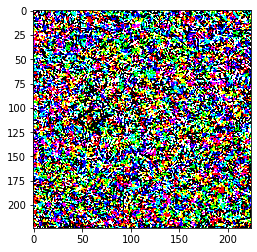

Imagen original


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


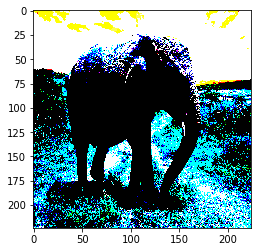

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Imagen + ruido 


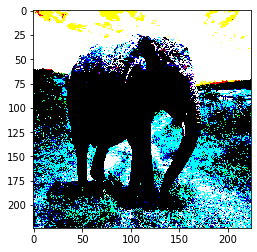

Prediccion img original [('n02504458', 'African_elephant', 0.86625427), ('n02504013', 'Indian_elephant', 0.06860924), ('n01871265', 'tusker', 0.06478469)]
0.78276473
Predicción img adversarial [('n02504458', 'African_elephant', 0.78276473), ('n01871265', 'tusker', 0.13702771), ('n02504013', 'Indian_elephant', 0.0794206)]
[('n02504458', 'African_elephant', 0.78276473), ('n01871265', 'tusker', 0.13702771), ('n02504013', 'Indian_elephant', 0.0794206)]


In [28]:
#Recuperamos los parámetros de la capa de ruido
ruido = adversarial_model.get_weights()[0].reshape((224,224,3))
print('Ruido')
print('Valor absoluto máximo', np.max(np.abs(ruido)))
plotImage(ruido)
imagen_adversarial = x + ruido
print('Imagen original')
plotImage(x[0])
print('Imagen + ruido ')
plotImage(imagen_adversarial[0])
print('Prediccion img original',decode_predictions(model.predict(x), top=3)[0] )
pred_advs = model.predict(imagen_adversarial)[0]
print(pred_advs[target])
print('Predicción img adversarial',decode_predictions(model.predict(imagen_adversarial), top=3)[0])
print(clasifica_mod_adversarial({'image':x,'unity':np.ones(shape=(1,1))}, adversarial_model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


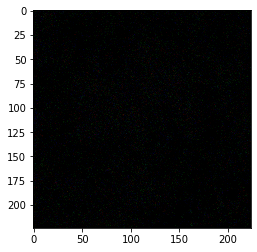

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[('n02504458', 'African_elephant', 0.86655), ('n02504013', 'Indian_elephant', 0.06839117), ('n01871265', 'tusker', 0.06470819)]


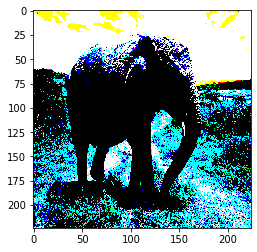

In [3]:
#adversarial_model.summary()
#np.save('imagen_adversarial_resnet', imagen_adversarial)
c = np.load('imagen_adversarial_resnet.npy')
#np.save('ruido_adversarial',ruido)
r = np.load('ruido_adversarial.npy')
plotImage(r)
print(decode_predictions(model.predict(c), top=3)[0])
plotImage(c[0])


In [ ]:
target_vector = np.zeros((1,1000))
target_vector[0,4] = 1
pred = model.predict(x)
print(np.argmax(pred))
print(np.argmax(target_vector))
print(adversarial_model.evaluate({'image':x,'unity':np.ones(shape=(1,1))}, target_vector))